-------

<h1 align="center"> Data Exploration </h1><br>
This notebook explores the provided crop and livestock predicts from FAOSTAT. Scatterplots were generated comparing disease mortality rates per 100,000 and food item consumption in kg/capita/year. This analysis was extended for cancer, diabetes, and cardiovascular disease and over 100 predictors were examined. The top positively and negatively correlated predictors are printed below.

***

In [425]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
import math
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score as val_score
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split as sk_split
import statsmodels.api as sm

%matplotlib inline

The following two cells read in data for crop and livestock predictors respectively from the origin sources.

In [426]:
#read in crops
allcrops_2000 = pd.read_csv('datasets/allcrops_2000.csv')
# names of all the crops
crop_names = allcrops_2000['Item'].unique()

# remove nan
crop_names = crop_names[:-1]
# list to put our separated crop dataframes
all_crop_dfs = []

# find each crop-separated df and put it in the list of dataframes
for crop in crop_names:
    crop_df = allcrops_2000[(allcrops_2000['Item'] == crop)]
    all_crop_dfs.append(crop_df)

print "List of all crop predictors: \n", crop_names

List of all crop predictors: 
['Apples and products' 'Bananas' 'Barley and products' 'Beer'
 'Beverages, Alcoholic' 'Cereals, Other' 'Citrus, Other'
 'Cocoa Beans and products' 'Coconuts - Incl Copra' 'Coffee and products'
 'Cottonseed Oil' 'Dates' 'Fruits, Other' 'Grapes and products (excl wine)'
 'Groundnut Oil' 'Infant food' 'Maize and products' 'Millet and products'
 'Nuts and products' 'Oilcrops Oil, Other' 'Olive Oil'
 'Olives (including preserved)' 'Oranges, Mandarines' 'Palm Oil' 'Pepper'
 'Pineapples and products' 'Potatoes and products'
 'Pulses, Other and products' 'Rape and Mustard Oil'
 'Rice (Milled Equivalent)' 'Rice (Paddy Equivalent)'
 'Roots & Tuber Dry Equiv' 'Sesame seed' 'Sesameseed Oil' 'Soyabean Oil'
 'Spices, Other' 'Sugar (Raw Equivalent)' 'Sugar, Raw Equivalent'
 'Sugar, Refined Equiv' 'Sunflowerseed Oil' 'Sweeteners, Other'
 'Tea (including mate)' 'Tomatoes and products' 'Vegetables, Other'
 'Wheat and products' 'Wine' 'Beans' 'Beverages, Fermented'
 'Cassava

In [427]:
# Do the same as above, but for livestock
livestock_2000 = pd.read_csv('datasets/livestock_2000.csv')
# list of livestock names
livestock_names_all = livestock_2000['Item'].unique()
livestock_names_all = livestock_names_all[1:-1]
livestock_names = []
for name in livestock_names_all:
    if name != 'Grand Total':
        livestock_names.append(name)

# list to put our separated dataframes
livestock_dfs = []

# separate dataframe based on itemname
for crop in livestock_names:
    crop_df = livestock_2000[(livestock_2000['Item'] == crop)]
    livestock_dfs.append(crop_df)

print "List of all livestock predictors: \n", livestock_names

List of all livestock predictors: 
['Butter, Ghee', 'Cheese', 'Cream', 'Eggs', 'Fats, Animals, Raw', 'Freshwater Fish', 'Honey', 'Meat, Other', 'Milk - Excluding Butter', 'Milk, Whole', 'Mutton & Goat Meat', 'Offals, Edible', 'Poultry Meat', 'Aquatic Animals, Others', 'Aquatic Plants', 'Cephalopods', 'Crustaceans', 'Demersal Fish', 'Fish, Body Oil', 'Fish, Liver Oil', 'Marine Fish, Other', 'Molluscs, Other', 'Pelagic Fish', 'Pigmeat', 'Whey', 'Meat, Aquatic Mammals']


The next step is to read in disease data and separate 2000 data from 2012 data for analysis. Since 2000 food data is more plentiful, we chose to focus on that year for more accurate model results with less extrapolation.

In [428]:
# read in disease rates
column_headers = ["Country", "Year", "Mortality", "Mortality 2", "Mortality 3"]
diabetes = pd.read_csv('datasets/diabetes.csv', names = column_headers)
cardio = pd.read_csv('datasets/cardiovascular.csv', names = column_headers)
cancer= pd.read_csv('datasets/Cancer.csv', names = column_headers)
all_foods = all_crop_dfs

In [429]:
cardio.iloc[3:, 0:3].head(n=5)
#cardio.columns = ['Country', 'Year', 'Mortality']

,Country,Year,Mortality
3,Afghanistan,2012,511.5
4,Afghanistan,2000,542.3
5,Albania,2012,436.2
6,Albania,2000,560.5
7,Algeria,2012,396.6


In [430]:
# separate out 2012 and 2000 data
cardio_2012 = cardio[(cardio["Year"] == "2012")] 
cardio_2000 = cardio[(cardio["Year"] == "2000")] 
diabetes_2012 = diabetes[(diabetes['Year'] == '2012')] 
diabetes_2000 = diabetes[(diabetes['Year'] == '2000')] 
cancer_2012 = cancer[(cancer['Year'] == ' 2012')] 
cancer_2000 = cancer[(cancer['Year'] == ' 2000')] 

In [431]:
cardio_2012.head(n=5)

,Country,Year,Mortality,Mortality 2,Mortality 3
3,Afghanistan,2012,511.5,520.9,498.0
5,Albania,2012,436.2,417.6,447.4
7,Algeria,2012,396.6,359.9,434.6
9,Angola,2012,374.6,369.8,376.4
11,Argentina,2012,191.7,148.4,247.8


In [432]:
cardio_2000.head(n=5)

,Country,Year,Mortality,Mortality 2,Mortality 3
4,Afghanistan,2000,542.3,554.1,523.1
6,Albania,2000,560.5,494.7,638.6
8,Algeria,2000,434.7,401.2,472.2
10,Angola,2000,383.4,385.2,375.2
12,Argentina,2000,226.6,169.1,302.8


# R Squared Predictor Analysis

The food disease plot below concatenates a separate list of food amounts and disease morality rates for each country. It has the potential to plot the information on a scatterplot with each country as a separate datapoint and uses linear regression to obtain an R squared value. These R squared values are first used to find suggestive food predictors. Then, scatterplots are generated to understand the nature of the correlation.

In [433]:
# plot for cardio
def food_disease_plot(disease_name, disease, food_df, ax):
    score = 1
    morts = []
    food_amts = []
    
    # for each country
    for country in food_df['Country'].values:
        # make sure it's in the disease df
        if not disease[(disease['Country'] == country)].empty:
            # find the disease data for that country
            country_data = disease[(disease['Country'] == country)]
            # find mortality rate
            mort = country_data.iloc[1,2]
            # append to mortality list
            morts.append(float(mort))
            # find amount of that particular food consumed in that country
            food_amt = food_df[(food_df['Country'] == country)]["Value"]
            # append to food_amounts
            food_amts.append(float(food_amt))
    
    # scatter the amounts against mortality rates
    ax.scatter(food_amts, morts)
    
    # reshape for LinReg to get R^2
    X = np.array(food_amts).reshape(-1, 1)
    y = np.array(morts)
    
    if (len(food_df['Item'].values) > 0) and (X.shape[0] > 0):
        # linreg
        regr = LinReg()
        # fit, score linreg
        regr.fit(X, y)
        score = regr.score(X,y)
        ax.set_title("R^2 = " + str(score))
    
    ax.set_xlabel((food_df['Item'].values[0]) + str(' (kg/capita/yr)'))
    ax.set_ylabel(str(disease_name) + ' Disease Mortality Rate')
    
    return ax, score

The following three cells run the above function on cardiovascular, diabetes, and cancer data respectively.

In [441]:
# cardio and crops r2
cardio_crop_r2 = {}

# go through and plot each one
for df, ax in zip(all_crop_dfs, axes):
    ax, r2 = food_disease_plot("Cardio", cardio, df, ax)
    crop_name = df['Item'].values[0]
    cardio_crop_r2[crop_name] = r2
    
# cardio and livestock r2
cardio_livestock_r2 = {}

# go through and plot each one
for df, ax in zip(livestock_dfs, axes):
    ax, r2 = food_disease_plot("Cardio", cardio, df, ax)
    crop_name = df['Item'].values[0]
    cardio_livestock_r2[crop_name] = r2

In [442]:
# diabetes and crops r2
diabetes_crop_r2 = {}

# go through and plot each one
for df, ax in zip(all_crop_dfs, axes):
    ax, r2 = food_disease_plot("Diabetes", diabetes, df, ax)
    crop_name = df['Item'].values[0]
    diabetes_crop_r2[crop_name] = r2
    
# diabetes and livestock r2
diabetes_livestock_r2 = {}

# go through and plot each one
for df, ax in zip(livestock_dfs, axes):
    ax, r2 = food_disease_plot("Diabetes", diabetes, df, ax)
    crop_name = df['Item'].values[0]
    diabetes_livestock_r2[crop_name] = r2

In [443]:
# cancer and crop r2
cancer_crop_r2 = {}

# go through and plot each one
for df, ax in zip(all_crop_dfs, axes):
    ax, r2 = food_disease_plot("Cancer", cancer, df, ax)
    crop_name = df['Item'].values[0]
    cancer_crop_r2[crop_name] = r2
    
# cancer and livestock r2
cancer_livestock_r2 = {}

# go through and plot each one
for df, ax in zip(livestock_dfs, axes):
    ax, r2 = food_disease_plot("Cancer", cancer, df, ax)
    crop_name = df['Item'].values[0]
    cancer_livestock_r2[crop_name] = r2

The following cells below combines crop and livestock predictors together into one dictionary for more thorough food predictor analysis so the impact can be compared directly. The predictors for each disease are then sorted by impact level to identify the most informative predictors.

In [444]:
# dictionary of all dataframes, crop and livestock
all_dfs = {}
for df in all_crop_dfs:
    crop_name = df['Item'].values[0]
    all_dfs[crop_name] = df

for df in livestock_dfs:
    crop_name = df['Item'].values[0]
    all_dfs[crop_name] = df

In [445]:
for k, v in cancer_livestock_r2.items():
    cancer_crop_r2[k] = v
for k, v in diabetes_livestock_r2.items():
    diabetes_crop_r2[k] = v
for k, v in cardio_livestock_r2.items():
    cardio_crop_r2[k] = v

In [447]:
cancer_r2_sort = sorted(cancer_crop_r2.items(), key= lambda x: -x[1])
diabetes_r2_sort = sorted(diabetes_crop_r2.items(), key= lambda x: -x[1])
cardio_r2_sort = sorted(cardio_crop_r2.items(), key= lambda x: -x[1])

In [448]:
def predictors_plot(disease, disease_sort):
    item_array = []
    r2_array = []
    for item, r2 in disease_sort:
        item_array.append(item)
        r2_array.append(r2)
    print "Top 15 Most important", disease, "predictors and their corresponding r squared values: \n", disease_sort[0:15]
    plt.barh(range(len(r2_array[0:15])),r2_array[0:15],align='center')
    plt.yticks(range(len(item_array[0:15])),item_array[0:15])
    plt.xlabel('R Squared Value')
    plt.ylabel('Predictor Name')
    plt.title('Relative importance of Each Food in Predicting ' + str(disease) + ' Morality Rates')
    plt.show()
    top15 = item_array[0:15]
    return top15

Top 15 Most important Cancer predictors and their corresponding r squared values: 
[('Potatoes and products', 0.18146714554204713), ('Fats, Animals, Raw', 0.13836803444212109), ('Apples and products', 0.12685735601591541), ('Palm Oil', 0.11992349320211892), ('Offals, Edible', 0.11226383680455887), ('Beverages, Alcoholic', 0.11173519114238595), ('Milk - Excluding Butter', 0.11142412953358283), ('Pigmeat', 0.11016505762966677), ('Cream', 0.10011991409978982), ('Pulses, Other and products', 0.099056591094852209), ('Cheese', 0.098148069716460173), ('Eggs', 0.094839037277499871), ('Beer', 0.090596219495131525), ('Wine', 0.074326137388987967), ('Cocoa Beans and products', 0.071497244953764749)]


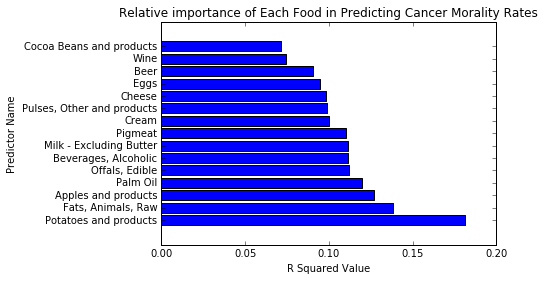

In [449]:
cancer_top15 = predictors_plot("Cancer", cancer_r2_sort)

Top 15 Most important Diabetes predictors and their corresponding r squared values: 
[('Potatoes and products', 0.2329604980119504), ('Milk - Excluding Butter', 0.19969407923376481), ('Pigmeat', 0.19253767532389077), ('Apples and products', 0.15652111902923338), ('Cheese', 0.14383934926938957), ('Wine', 0.12702378306686479), ('Milk, Whole', 0.11984650853887568), ('Eggs', 0.1146558328529067), ('Cream', 0.10908691840397299), ('Coffee and products', 0.10560223330637797), ('Pulses, Other and products', 0.099760132258112977), ('Rye and products', 0.098480879238826757), ('Rape and Mustard Oil', 0.098442076113427812), ('Butter, Ghee', 0.095543733389780616), ('Beer', 0.094928757240494432)]


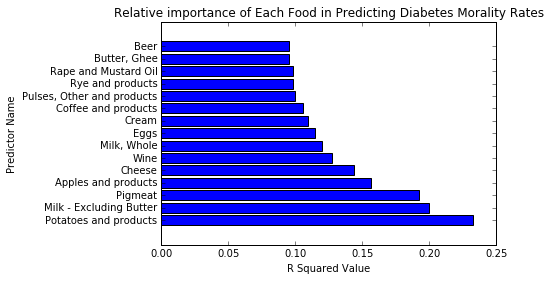

In [450]:
diabetes_top15 = predictors_plot("Diabetes", diabetes_r2_sort)

Top 15 Most important Cardio predictors and their corresponding r squared values: 
[('Wheat and products', 0.1769115917312033), ('Cottonseed Oil', 0.16233585584342736), ('Coffee and products', 0.150944981458219), ('Oranges, Mandarines', 0.14045290297240975), ('Molluscs, Other', 0.1148933629111597), ('Cheese', 0.11437142383705025), ('Beer', 0.11153274849099704), ('Poultry Meat', 0.1092773280445376), ('Sugar, Raw Equivalent', 0.1006500283481213), ('Crustaceans', 0.095665062661258848), ('Pigmeat', 0.088258357775067631), ('Soyabean Oil', 0.088158071312481545), ('Ricebran Oil', 0.085285860529225266), ('Cephalopods', 0.083990040870099314), ('Rape and Mustard Oil', 0.083554953546264077)]


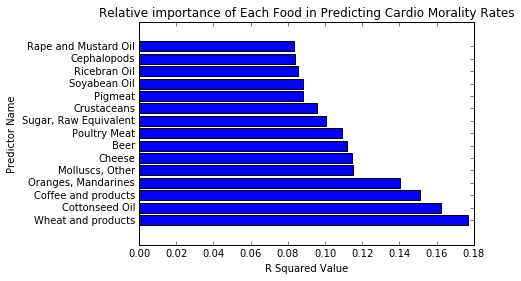

In [451]:
cardio_top15 = predictors_plot("Cardio", cardio_r2_sort)

The above bar graphs display the most predictors with the highest R squared values in comparing food consumption quantity to disease mortality rates. It indicates a preliminary breakdown of critical foods that have a linear relationship. These foods suggest the presence of a linear relationship but it is worth noting that it does not speak to the magnitude of the impact, which is rather conveyed by the size of the coefficient, explored in the Data Analysis chapter.

For cancer and diabetes, the most predictive food item were potatoes and products and it was wheat and products for cardiovascular disease. Based on these values alone, it appears that carbohydrate heavy foods have a relationship with disease incidence rates. However R squared values does not tell you about the nature of this relationship: whether additional consumption increases or decreases the risk of contracting a disease. We observe that apples and products also rank highly as a predictor for cancer and diabetes. Intuitively, carbohydrate loaded foods should increase the risk the non-communicable disease while fruits and vegetables should decrease the risk. However, we cannot verify these theories from a single value alone. To further study these trends, we decided to generate scatterplots of the data to understand our observations from a granular, country-level prespective. 

# Scatterplot Visualizations

In [453]:
def top_15(disease_top15, disease_name, disease):
    # aggregate dataframes of top 15 combined crop and livestock predictors
    top_15 = []
    for each in disease_top15:
        top_15.append(all_dfs[each])

    # plot scatterplots of top 15 predictors
    fig, ax = plt.subplots(3, 5, figsize=(25, 15))
    axes = [e for l in ax for e in l]

    top_15_r2 = {}

    for df, ax in zip(top_15, axes):
        ax, r2 = food_disease_plot(disease_name, disease, df, ax)
        livestock_name = df['Item'].values[0]
        top_15_r2[livestock_name] = r2

    plt.tight_layout()
    plt.show()

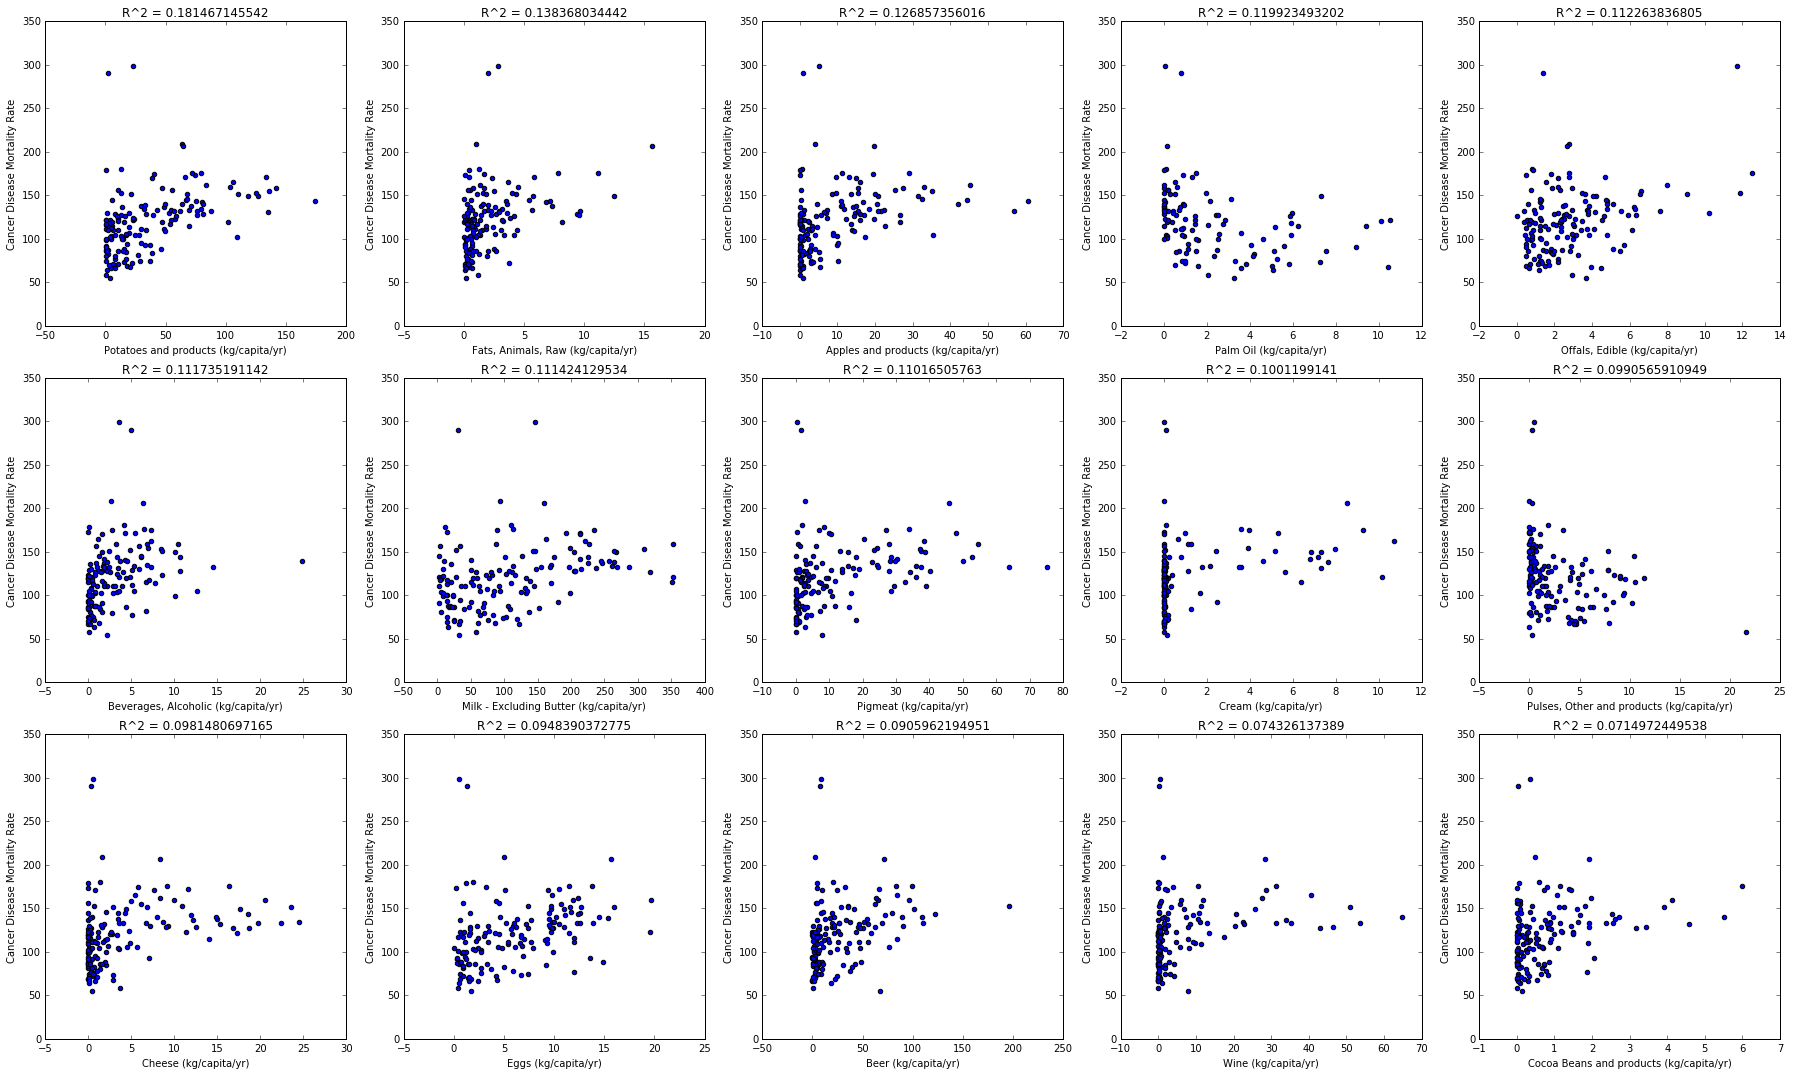

In [454]:
top_15(cancer_top15, "Cancer", cancer)

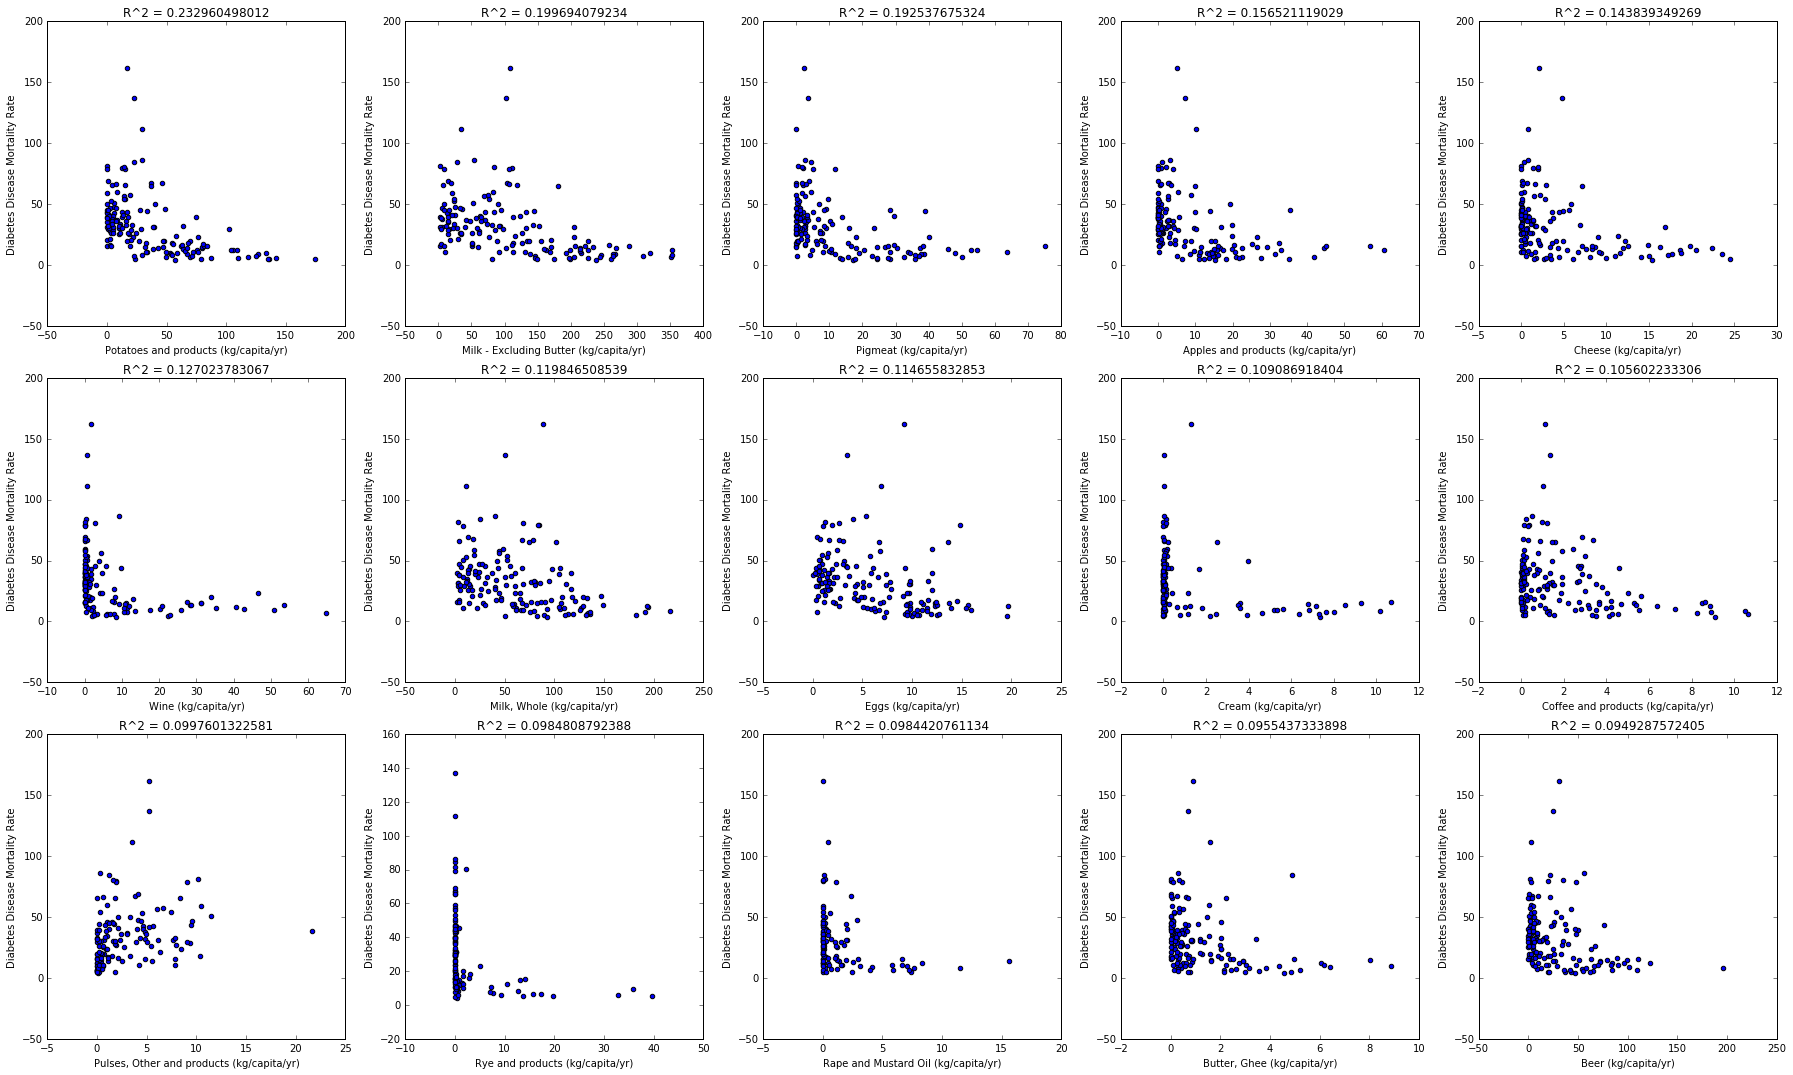

In [455]:
top_15(diabetes_top15, "Diabetes", diabetes)

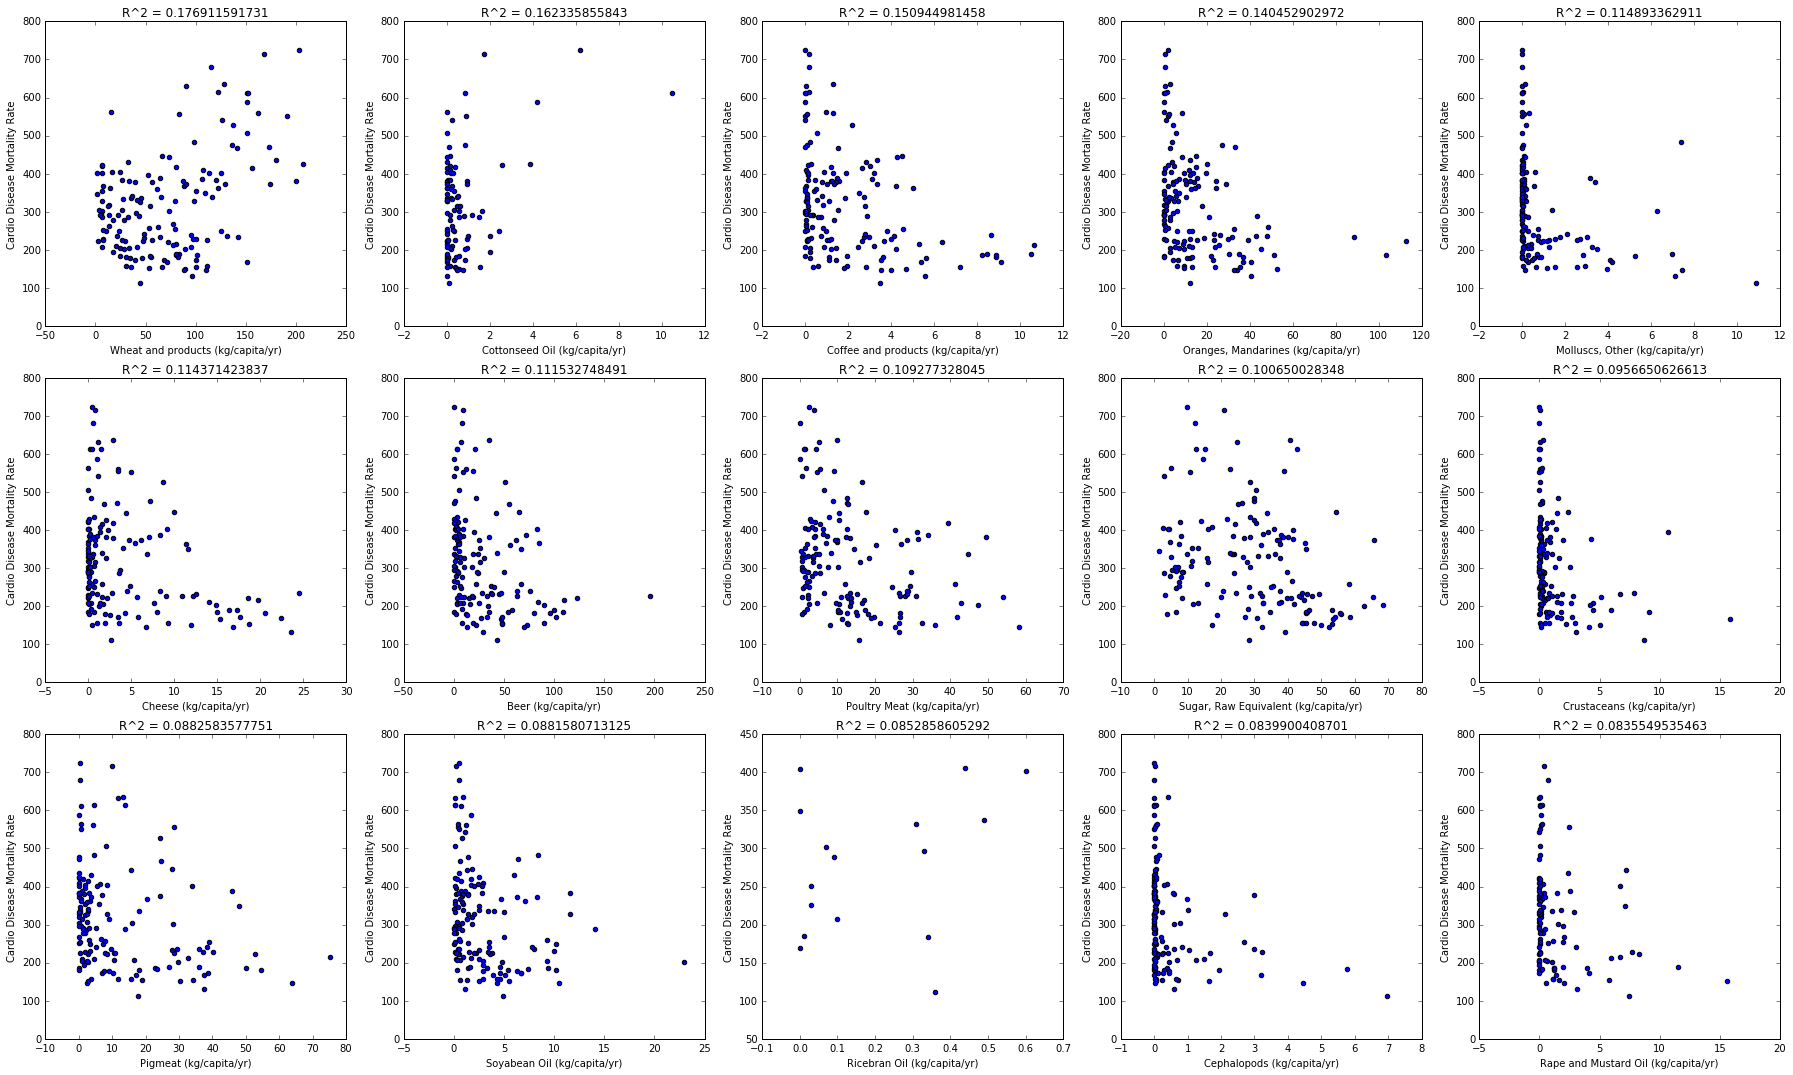

In [456]:
top_15(cardio_top15, "Cardio", cardio)

From the scatterplots presented, it appears that our intuition is correct. Potatoes and products have a direct positive correlation for cancer and wheat and products have a postiive correlation with cardiovascular disease. Consumption of these products increases your risk while consumption of fruits and vegetables have an inverse relationship. Interestingly, potatoes and products have an inverse relationship with diabetes. This implies that the same predictors responds differently across diseases. Based on this research, we would want to calculate food predictor impact for the three diseases individually.